In [123]:
import os, os.path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import matplotlib.patches as patches
import glob
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
from torch import nn, Tensor
import torch.optim as optim

from typing import List

---

# Data

In [124]:
def load_data(folder = "../backend-project/data/", filenames_to_keep=None):
    '''
    Load the data about each image, the names of the images used for training, the name of the ones used for testing
    and the bounding boxes.

    Parameters
    ----------
    folder : optional, str
        The folder where the data is stored
    filenames_to_keep : optional, np.array(M,)
        List of all the filenames we want to keep, the other will be filtered. Default is None, meaning we 
        want to keep all the data in the folder.

    Return
    ----------
    data, train_val_filenames, test_filenames, bounding_boxes: 
    pd.DataFrame(N, 11), np.array(V, ), np.array(T, ),  pd.DataFrame(B, 6)
        The data contains the info on the image such as disease, patient id/age, resolution.
        The train_val_filenames contains the name of the images used for training/validation
        The test_filenames contains the name of the images used for testing
        The bounding_boxes contains the info on the bboxes of known diseases which are the name of the file
        and the disease, the x,y coordinates of the top left corner and the width and height of the box.
    '''
    data = pd.read_csv(folder + "Data_Entry_2017_v2020.csv")
    train_val_filenames = np.array(pd.read_csv(folder + "train_val_list.txt", names=["filename"])['filename'].tolist())
    test_filenames = np.array(pd.read_csv(folder + "test_list.txt", names=["filename"])['filename'].tolist())
    bounding_boxes = pd.read_csv(folder + "BBox_List_2017.csv")
    
    data = data.rename(columns={"Image Index": "Filename", "Finding Labels": "Diseases", "OriginalImage[Width":"Original Width", "Height]": "Original Height", "OriginalImagePixelSpacing[x": "Original Pixel Spacing x", "y]": "Original Pixel Spacing y"})
    bounding_boxes=bounding_boxes.loc[:, ~bounding_boxes.columns.str.contains('^Unnamed')].rename(columns={"Image Index": "Filename", "Finding Label": "Disease", "Bbox [x" : "x", "h]": "h"})
    
    if filenames_to_keep is not None:
        data = data[data["Filename"].isin(filenames_to_keep)]
        bounding_boxes = bounding_boxes[bounding_boxes["Filename"].isin(filenames_to_keep)]
        test_filenames = test_filenames[np.isin(test_filenames, filenames_to_keep)]
        train_val_filenames = train_val_filenames[np.isin(train_val_filenames, filenames_to_keep)]
        
    return data, train_val_filenames, test_filenames, bounding_boxes

In [125]:
def read_image(path):
    '''
    Read an image in memory

    Parameters
    ----------
    path : str
        The path to the image (folder + filename)

    Return
    ----------
    np_img: np.array(X, Y):
        The image (not scaled) stored in this path
    '''
    img = Image.open(path)
    np_img = np.array(img)

    return np_img

def scale_image(np_img):
    '''
    Scale an image from range [0, 255] to range [0, 1]

    Parameters
    ----------
    np_img : np.array(X, Y)
        The unscaled ([0, 255]) image

    Return
    ----------
    np.array(X, Y):
        The scaled ([0, 1]) image
    '''
    return np_img/255

In [126]:
class XRayDataset(Dataset):
    '''
    Class to represent our dataset of XRay images. Subclass of torch.utils.data.Dataset. Store the image directory,
    images name, bounding boxes and data of the images we will use either for training or testing.
    '''
    def __init__(self, img_dir, transform=None, train=True):
        '''
        Constructor

        Parameters
        ----------
        img_dir : str
            Directory where the images are stored. Will take all the png files present in this directory
        transform: optional, function
            Transformation used on every image before returning it such as scaling.
        train: optional, Boolean
            If set to true, we keep only the training data in the corresponding folder and otherwise the testing one
        '''
        self.img_dir = img_dir
        # Read all the names of the PNG files in the directory
        images_name = np.array([name for name in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, name)) and re.search('png$', name) is not None])
        data, train_names, test_names, bounding_boxes = load_data(filenames_to_keep = images_name)
        
        # Keep only the training or test ones
        self.data = data[data["Filename"].isin((train_names if train else test_names))]
        self.bounding_boxes = bounding_boxes[bounding_boxes["Filename"].isin((train_names if train else test_names))]
        self.images_name = images_name[np.isin(images_name, (train_names if train else test_names))]
        
        self.transform = transform
        
    def __len__(self):
        '''
        Overload: return the length of the dataset

        Return
        ----------
        length: int:
            The length of the dataset
        '''
        return self.images_name.shape[0]

    def __getitem__(self, idx):
        '''
        Overload; get the item (only image for the moment) corresponding to the given idx.

        Parameters
        ----------
        idx : int
            Index of the item we want to get.

        Return
        ----------
        image: np.array(X, Y):
            The corresponding image transformed with the transform method
        '''
        img_path = os.path.join(self.img_dir, self.images_name[idx])
        image = read_image(img_path)
        
        if(len(image.shape) > 2): #Some images have more than one channel for unknown reasons
            image = image[:, :, 0]

        data = self.data[self.data["Filename"] == self.images_name[idx]]
        
        bbox = None
        if not self.bounding_boxes[self.bounding_boxes["Filename"] == self.images_name[idx]].empty:
            bbox = self.bounding_boxes[self.bounding_boxes["Filename"] == self.images_name[idx]]
        
        if self.transform:
            image = self.transform(image)
#             if image.shape[0] == 1:
#                 image = image.squeeze()

        return image#, data, bbox # Cannot pass data and bbox for the moment because they contain entries of type "object" which is a problem for dataloader. Should transform the few entries having object type

---

# Model

## Variational Encoder

In [127]:
class VariationalEncoder(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super().__init__()

        modules = []
        if hidden_dims is None:
            hidden_dims = [4, 16, 32, 64, 128]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*32*32, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*32*32, latent_dim)
    
    def forward(self, input: torch.Tensor) -> List[torch.Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

## Decoder

In [128]:
class Decoder(nn.Module):
    def __init__(self,
                 encoder_in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super().__init__()
        
        self.encoder_in_channels = encoder_in_channels
        
        modules = []
        if hidden_dims is None:
            hidden_dims = [128, 64, 32, 16, 4]

        # Build Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0] * 32 * 32)

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels=encoder_in_channels,
                                      kernel_size=3, padding=1),
                            nn.Tanh())

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 128, 32, 32)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

## Beta-VAE

In [129]:
class BetaVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims_encoder: List = None,
                 hidden_dims_decoder: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super().__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter
        self.num_iter = 0
        
        self.variational_encoder = VariationalEncoder(in_channels, latent_dim, hidden_dims_encoder)
        self.decoder = Decoder(in_channels, latent_dim, hidden_dims_decoder)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: torch.Tensor, **kwargs) -> torch.Tensor:
        mu, log_var = self.variational_encoder(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decoder(z), input, mu, log_var]
    
    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

---

# Training

In [130]:
def train(model, train_loader, num_epochs=5, verbose=1):
    '''
    Train the model.
    
    Parameters
    ----------
    model: nn.Module
        The model.
    train_loader: DataLoader
        A Pytorch Dataloader containing the training images.
    num_epochs: optional, int 
        The number of epochs to train.
    verbose: optional, int
        Set the number of printing we want during training. For the moment, only 0 for no printing or another value
        to get some information about the update.
    
    Return
    ----------
    loss_history: list
        A list of training losses. One for each epoch of training.
    '''
    loss_history = []
    for e in range(num_epochs):
        if verbose:
            print(f"=========== EPOCH {e} ===========")
        total_loss = 0
        number_samples = 0
        for i, batch in enumerate(train_loader):
            X = batch
            output = model(X)
            loss = loss_fn(*output)
            total_loss += loss["loss"].detach()
            number_samples += X.shape[0]
            optimizer.zero_grad()
            loss["loss"].backward()
            optimizer.step()
            
            if verbose and not i%100 and not i==0:
                print(f"Done processing batch number {i}")
        
        if verbose:
            print(f"Mean loss = {total_loss/number_samples}")
        
        loss_history.append(total_loss/number_samples)
    return loss_history

In [131]:
def plot_loss(epoch_losses, title='Loss'):
    '''
    Simple plot for the loss at each epoch.
    
    Parameters
    ----------
    epoch_losses: list
        A list of training losses. One for each epoch of training.
    title: optional, str
        the title of the plot.
    '''
    plt.figure()
    plt.plot(epoch_losses)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [132]:
# Compute the dataloader for training and testing using our custom dataset
IMG_DIR = "../backend-project/data/images/images/"
BATCH_SIZE = 2

training_data = XRayDataset(
    img_dir=IMG_DIR,
    train=True,
    transform=ToTensor() #This method directly scale the image in [0, 1] range
)

test_data = XRayDataset(
    img_dir=IMG_DIR,
    train=False,
    transform=ToTensor() #This method directly scale the image in [0, 1] range
)

train_loader = DataLoader(training_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

=========== EPOCH 0 ===========
Done processing batch number 100
Done processing batch number 200
Done processing batch number 300
Done processing batch number 400
Done processing batch number 500
Done processing batch number 600
Done processing batch number 700
Done processing batch number 800
Done processing batch number 900
Done processing batch number 1000
Done processing batch number 1100
Done processing batch number 1200
Done processing batch number 1300
Done processing batch number 1400
Done processing batch number 1500
Done processing batch number 1600
Done processing batch number 1700
Done processing batch number 1800
Done processing batch number 1900
Done processing batch number 2000
Mean loss = tensor([nan])


/Users/antoine/miniconda3/envs/xai/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


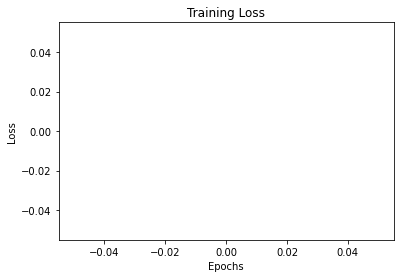

In [133]:
# Create our autoencoder and train it
# Parameters
NUM_EPOCHS = 1
LEARNING_RATE = 1e-3

LATENT_SPACE_DIM = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Model
beta_vae = BetaVAE(in_channels=1, latent_dim=16)

# Loss function & optimizer
loss_fn = beta_vae.loss_function
optimizer = optim.Adam(beta_vae.parameters(),
                       lr=LEARNING_RATE)

epoch_losses = train(beta_vae, train_loader, num_epochs=NUM_EPOCHS)
plot_loss(epoch_losses, 'Training Loss')

In [136]:
image_generated = beta_vae.generate(test_data[0])

AttributeError: 'BetaVAE' object has no attribute 'decode'